In [3]:
#install.packages("tidyr")
#install.packages("ggfortify")
#install.packages("ggrepel")
#install.packages("BiocManager")
#install.packages("WebGestaltR")
#Sys.setenv(R_INSTALL_STAGED = FALSE)
#BiocManager::install("DESeq2")
#BiocManager::install("cowplot")

In [9]:
library(tidyr)
library(DESeq2)
library(ggplot2)
library(reshape2)
library(dplyr)
library(Rtsne)
library(caret)
library(ggfortify)
library(ggrepel)
library(WebGestaltR)
library(RCurl)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [3]:
preparePCAplots = function(pca, metadata_of_interest){

    data_to_plot <- cbind(data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2]), metadata_of_interest)
    features_to_plot <- setdiff(colnames(data_to_plot), c("PC1", "PC2"))
    features_to_plot <- setNames(features_to_plot, features_to_plot)
    all_plots_pca <- lapply(features_to_plot,
           function(col) {
                        gg = ggplot(data = data_to_plot) + theme_minimal() + 
                        geom_point(aes(x = PC1, y = PC2, color = !!sym(col)), size = 5) +
                        theme(legend.position = "bottom", legend.margin=margin(t=0, unit="pt"),  
                              text = element_text(size=14), 
                              legend.title = element_text(size = 10),
                        legend.text = element_text(size = 10)) + xlab("") + ylab("") # xlim(-5,5) + ylim(-5,5)+ 
                        if (class(data_to_plot[,col]) == "factor")
                        gg = gg + guides(colour = guide_legend(title.position = "top", nrow = 2))
                        if (class(data_to_plot[,col]) == "character")
                        gg = gg + guides(colour = guide_legend(title.position = "top", nrow = 3))
                          
           return(gg)}
    )
    return(all_plots_pca)
}

In [2]:
inputfolder = "~/Pathonoia/OUTPUT/FTD/"
ds = "FTD"

# FTD mRNA

In [5]:
pca_outlier = c()

In [13]:
counts = read.table(paste0(inputfolder,ds,"_contamination_aggregated.csv"), sep = ",", header=TRUE, check.names = FALSE, row.names = "")

if(exists("pca_outlier")){
    print(pca_outlier)
    counts = counts[,!(colnames(counts) %in% pca_outlier)]
} else {
    pca_outlier = c()
}

pathoInfoCols = c("species_name","phylo_level","parent")
pathoInfo = counts[pathoInfoCols]
counts = counts[,!colnames(counts) %in% pathoInfoCols]

counts[is.na(counts)]=0
#counts

[1] "07083" "05217" "A144_"


In [14]:
metadata = read.table(paste0(inputfolder,"metadata.csv"))
rownames(metadata) = substr(rownames(metadata),1,5)
metadata = metadata[colnames(counts),]
metadata

t(as.data.frame(table(metadata$REGION)))
t(as.data.frame(table(metadata$MUTATED.GENE)))
table(metadata$CASE.CONTROL)
t(as.data.frame(table(metadata$DISEASE.CODE)))
t(as.data.frame(table(metadata$AGE)))
table(metadata$GENDER)

colnames(metadata)

,FLOWCELL,LANE,SAMPLEID,ORIGINALSAMPLENAME,REGION,CASE.CONTROL,DISEASE.CODE,MUTATED.GENE,GENE,Number_of_input_reads,⋯,PMD.MIN.,PH,Pipeline_Passed,MADE,SENT,LIBRARIES.DONE,NOTE,OBSERVATIONS,SOURCE,ALREADY.IN.GOOGLE
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<lgl>,<fct>,<fct>,<lgl>,<fct>
98169,BC894KANXX,5,98169,NA,frontal,case,FTD-C9,C9orf72,C9orf72,14921445,⋯,260,6.25,Yes,NA,NA,NA,NA,NA,NA,NA
00116,BC9AP9ANXX,3,116,NA,frontal,case,FTD-C9,C9orf72,C9orf72,10249720,⋯,330,6.66,Yes,120416,20516,NA,NA,Eldem´s second librarie,NA,Yes
00136,D10RJACXX,2,136,00_136_Frontal,frontal,case,FTD-MAPT,MAPT,P301L,24109642,⋯,300,6.3,Yes,NA,NA,NA,NA,NA,NA,NA
02218,D10MJACXX,8,2218,02_218_frontal,frontal,case,FTD-C9,C9orf72,C9orf72,34304121,⋯,545,6.23,Yes,NA,NA,NA,NA,NA,NA,NA
03121,D2D9FACXX,1,3121,03121_front,frontal,case,FTD-MAPT,MAPT,R406V,26866599,⋯,445,6.6,Yes,NA,NA,NA,NA,NA,NA,NA
04245,D10RJACXX,2,4245,04_245_Frontal,frontal,case,FTD-MAPT,MAPT,P301L,23336035,⋯,400,6.52,Yes,NA,NA,NA,NA,NA,NA,NA
04263,D2D9FACXX,1,4263,04263_front,frontal,case,FTD-MAPT,MAPT,G272V,11479519,⋯,450,6.46,Yes,NA,NA,NA,NA,NA,NA,NA
05052,D2D9FACXX,2,5052,05052_front,frontal,case,FTD-MAPT,MAPT,G272V,31264259,⋯,310,6.54,Yes,NA,NA,NA,NA,NA,NA,NA
05108,D2D9FACXX,3,5108,05108_front,frontal,case,FTD-MAPT,MAPT,L315R,28916964,⋯,340,6.6,Yes,NA,NA,NA,NA,NA,NA,NA


Var1,frontal
Freq,45


Var1,C9orf72,control,GRN,MAPT
Freq,12,15,6,11



   case control 
     30      15 

Var1,control,FTD-C9,FTD-GRN,FTD-MAPT,FTD-sporadic-TDP
Freq,15,12,6,11,1


Var1,42,49,51,52,54,58,59,60,63,64,⋯,74,75,76,82,83,84,85,87,88,89
Freq,1,2,1,2,1,1,1,4,3,3,⋯,1,2,2,1,2,2,1,1,1,2



 F  M 
25 20 

[1] "FLOWCELL"                        "LANE"                           
 [3] "SAMPLEID"                        "ORIGINALSAMPLENAME"             
 [5] "REGION"                          "CASE.CONTROL"                   
 [7] "DISEASE.CODE"                    "MUTATED.GENE"                   
 [9] "GENE"                            "Number_of_input_reads"          
[11] "Number_of_Uniquely_mapped_reads" "Ratio_of_uniquely_mapped_reads" 
[13] "RIN"                             "LINKERS"                        
[15] "BARCODE"                         "POOL"                           
[17] "AGE"                             "GENDER"                         
[19] "PMD"                             "PMD.MIN."                       
[21] "PH"                              "Pipeline_Passed"                
[23] "MADE"                            "SENT"                           
[25] "LIBRARIES.DONE"                  "NOTE"                           
[27] "OBSERVATIONS"                    "SOURCE"                         
[29] "ALREADY.IN.GOOGLE"

In [15]:
counts = read.table(paste0(inputfolder,ds,"_contamination_aggregated.csv"), sep = ",", header=TRUE, check.names = FALSE, row.names = "")
counts = counts[,!(colnames(counts) %in% pca_outlier)]
pathoInfo = counts[pathoInfoCols]
counts = counts[,!colnames(counts) %in% pathoInfoCols]
counts[is.na(counts)]=0

numberOfZerosAllowed = length(counts)*0.99
counts_lessSparse = counts[!(rowSums(counts == 0) > numberOfZerosAllowed),]
table(duplicated(counts_lessSparse))
counts = counts_lessSparse

metadata = read.table(paste0(inputfolder,"metadata.csv"))
rownames(metadata) = substr(rownames(metadata),1,5)
metadata = metadata[colnames(counts),]

cols_of_interest = c('FLOWCELL','CASE.CONTROL','DISEASE.CODE','MUTATED.GENE','RIN','AGE','GENDER')
metadata_of_interest = metadata[rownames(t(counts)),cols_of_interest]
metadata_of_interest = cbind(metadata_of_interest,t(counts["95485",rownames(metadata_of_interest)]))
metadata_of_interest$"95485" = as.numeric(metadata_of_interest$"95485")
metadata_of_interest$FLOWCELL = gsub('.{5}$', '', metadata_of_interest$FLOWCELL)


FALSE 
  431 

# PCA and TSNE

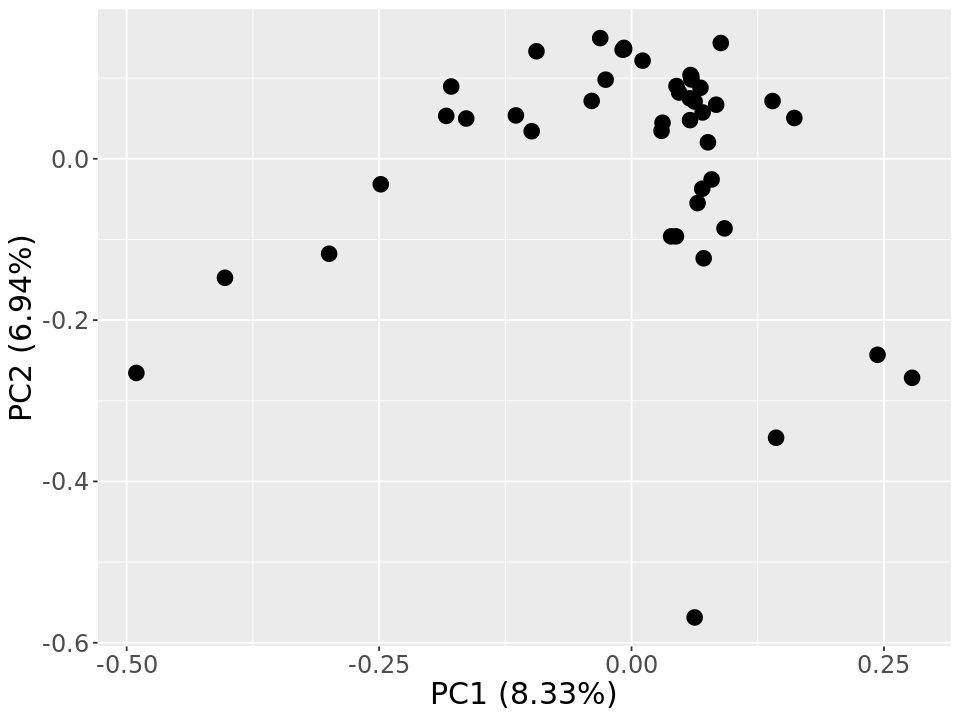

In [27]:
pca <- prcomp(t(counts), scale = TRUE)

options(repr.plot.width=8, repr.plot.height=6)
autoplot(pca, label = FALSE, size = 4) + theme(text = element_text(size=18))

all_plots_pca =  preparePCAplots(pca,metadata_of_interest)

In [5]:
pca_outlier = c('07083','05217','A144_')#,'09126_fro','00136_fro','12005_fro','10200_fro','09218_fro')
#pca_outlier = c()

# re-run cells from above after this

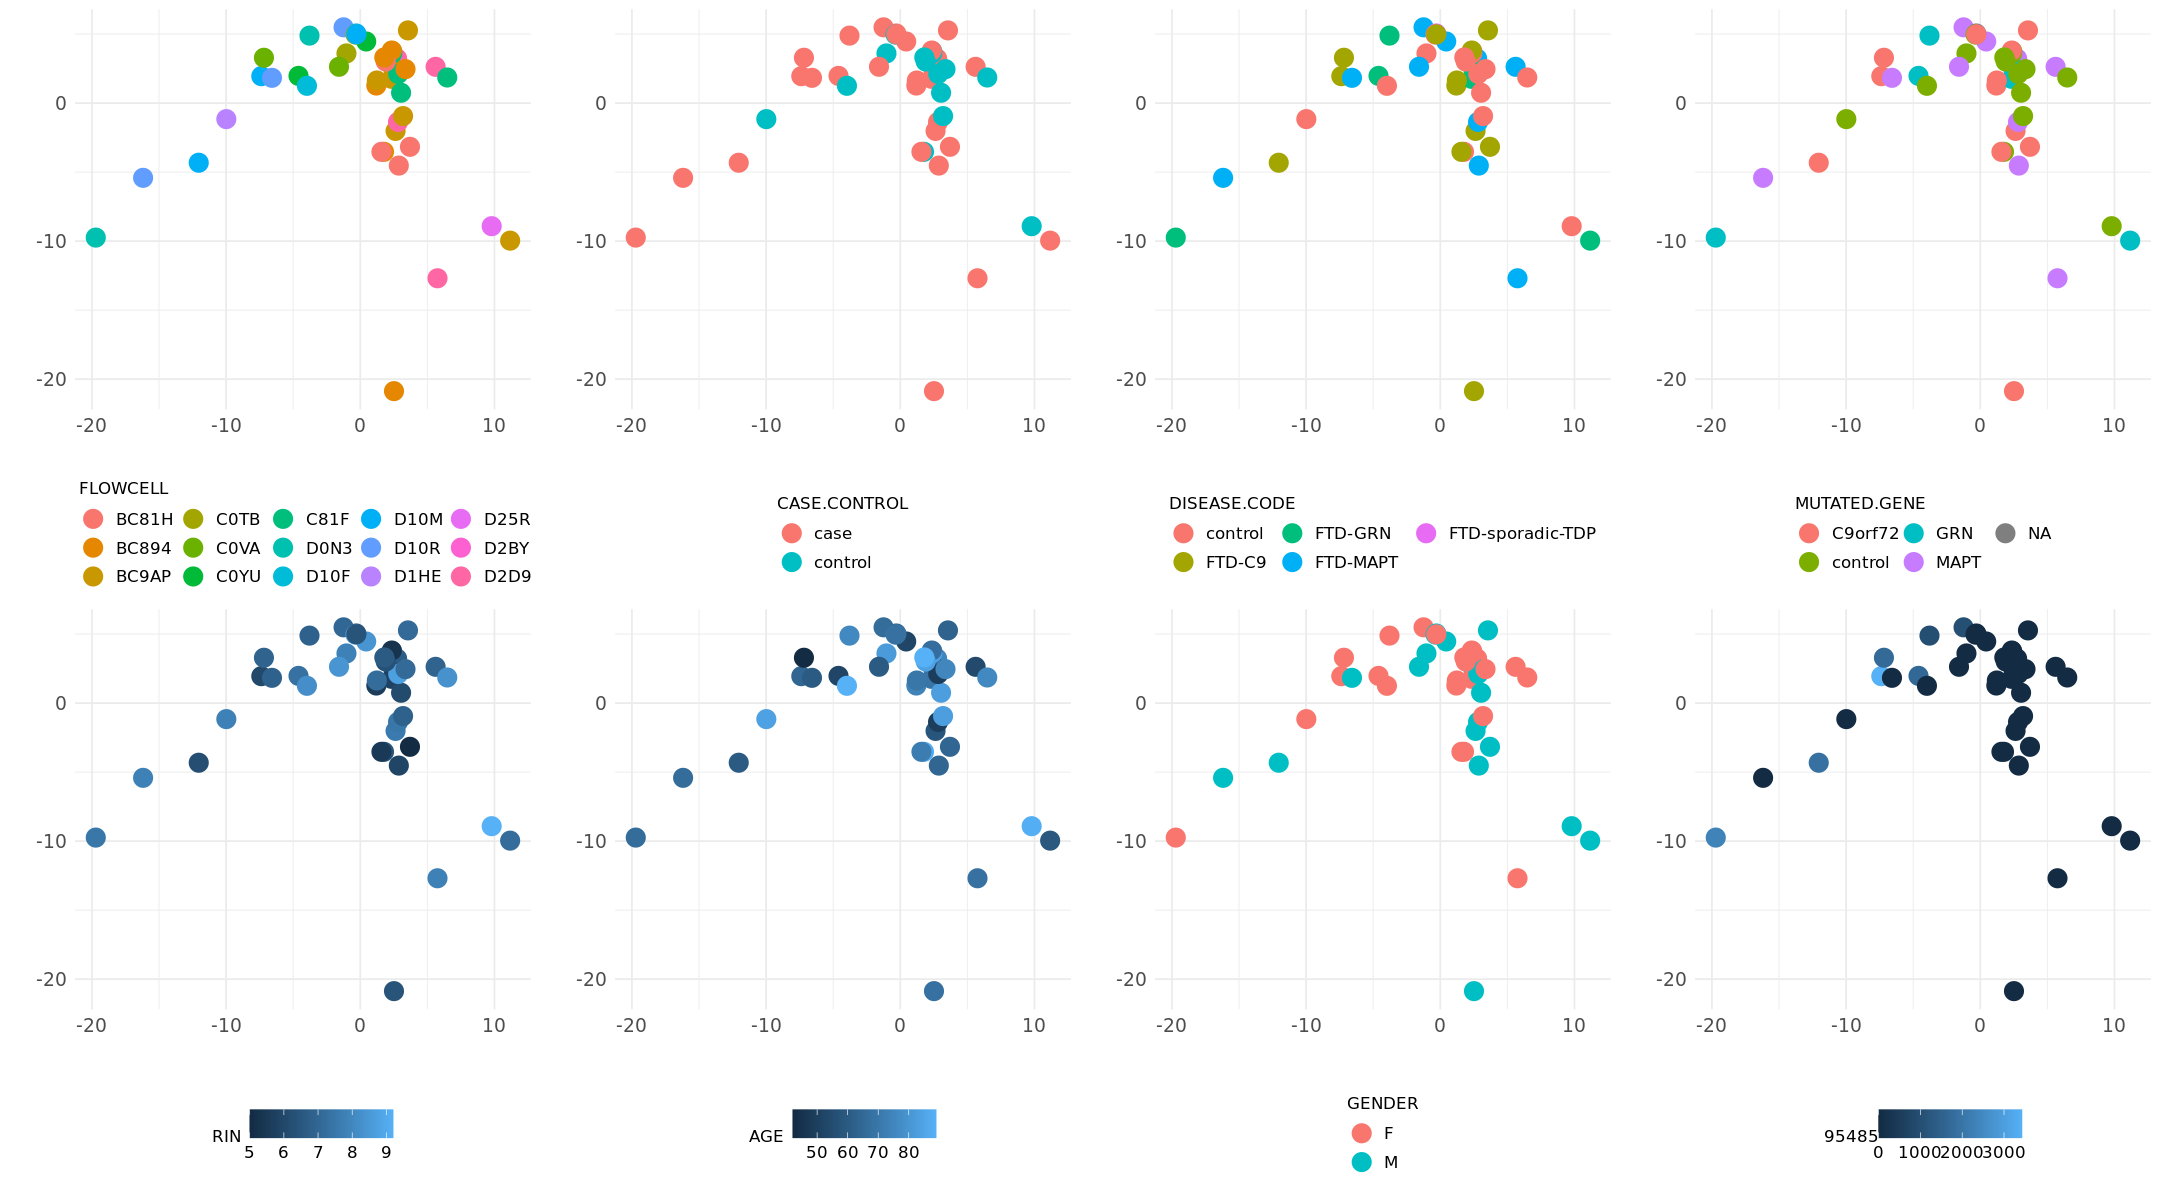

In [29]:
options(repr.plot.width=18, repr.plot.height=10)
cowplot::plot_grid(plotlist = all_plots_pca, ncol = 4, align = "h") 

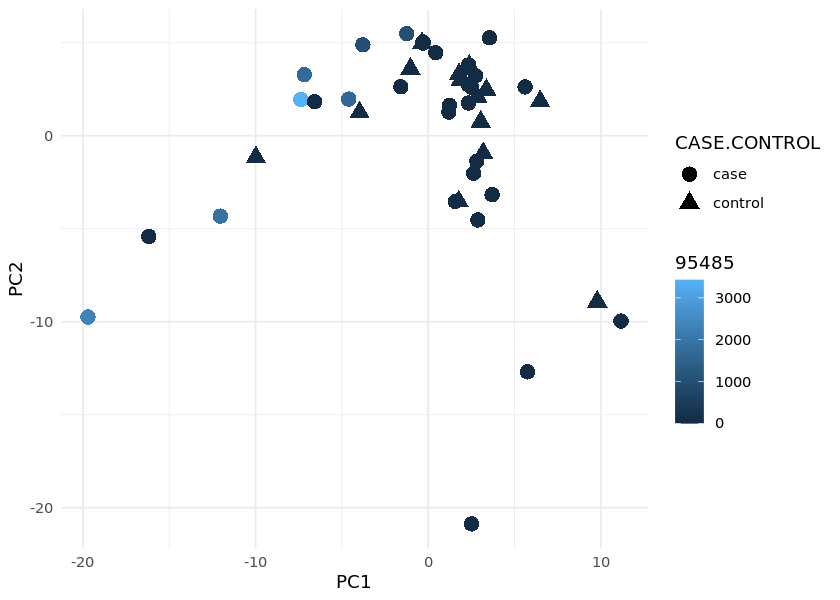

In [30]:
options(repr.plot.width=7, repr.plot.height=5)
data_to_plot <- cbind(data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2]), metadata_of_interest)
ggplot(data = data_to_plot, aes(x=PC1, y=PC2, color=`95485`, shape = CASE.CONTROL) ) + theme_minimal() + geom_point(size = 4)


# Differential Expression

In [31]:
samples = rownames(metadata_of_interest)
dds <- DESeqDataSetFromMatrix(countData = counts[,rownames(metadata)],
                              colData = metadata,
                              design= ~ CASE.CONTROL)
dds <- DESeq(dds)
resultsNames(dds) 

converting counts to integer mode

  it appears that the last variable in the design formula, 'CASE.CONTROL',
  has a factor level, 'control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 327 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                    "CASE.CONTROL_control_vs_case"

In [32]:
deres = as.data.frame(results(dds, name=resultsNames(dds)[2]))
r = cbind(pathoInfo[rownames(deres),pathoInfoCols],deres)
r = r[r$padj<0.05 & !is.na(r$padj),]
r = r[order(r$padj),]
r

,species_name,phylo_level,parent,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1094466,Flavobacterium indicum GPTSA100-9 = DSM 17447,S1,312277,957.006038,-28.88393,3.105402,-9.301192,1.388803e-20,1.736004e-18
95485,Burkholderia stabilis,S,87882,220.144848,-26.85486,2.922396,-9.189329,3.952986e-20,2.470616e-18
69665,Caulobacter sp. FWC26,S,2648921,454.838727,-27.85302,3.105410,-8.969193,2.986949e-19,1.244562e-17
147645,Paracoccus yeei,S,265,152.087039,27.49398,3.083026,8.917853,4.754130e-19,1.485666e-17
2565555,Sphingomonas sp. PAMC26645,S,196159,131.383032,-25.71649,3.105450,-8.281084,1.220587e-16,2.702545e-15
87883,Burkholderia multivorans,S,87882,181.246659,-25.69384,3.105435,-8.273831,1.297222e-16,2.702545e-15
28038,Lactobacillus curvatus,S,1578,49.674416,-24.74716,3.105542,-7.968707,1.603426e-15,2.863260e-14
2052837,Neisseriaceae bacterium DSM 100970,S,421605,27.466536,-24.01625,3.105662,-7.733052,1.049980e-14,1.640594e-13
1290,Staphylococcus hominis,S,1279,25.260805,-23.90268,3.105686,-7.696428,1.399231e-14,1.943377e-13


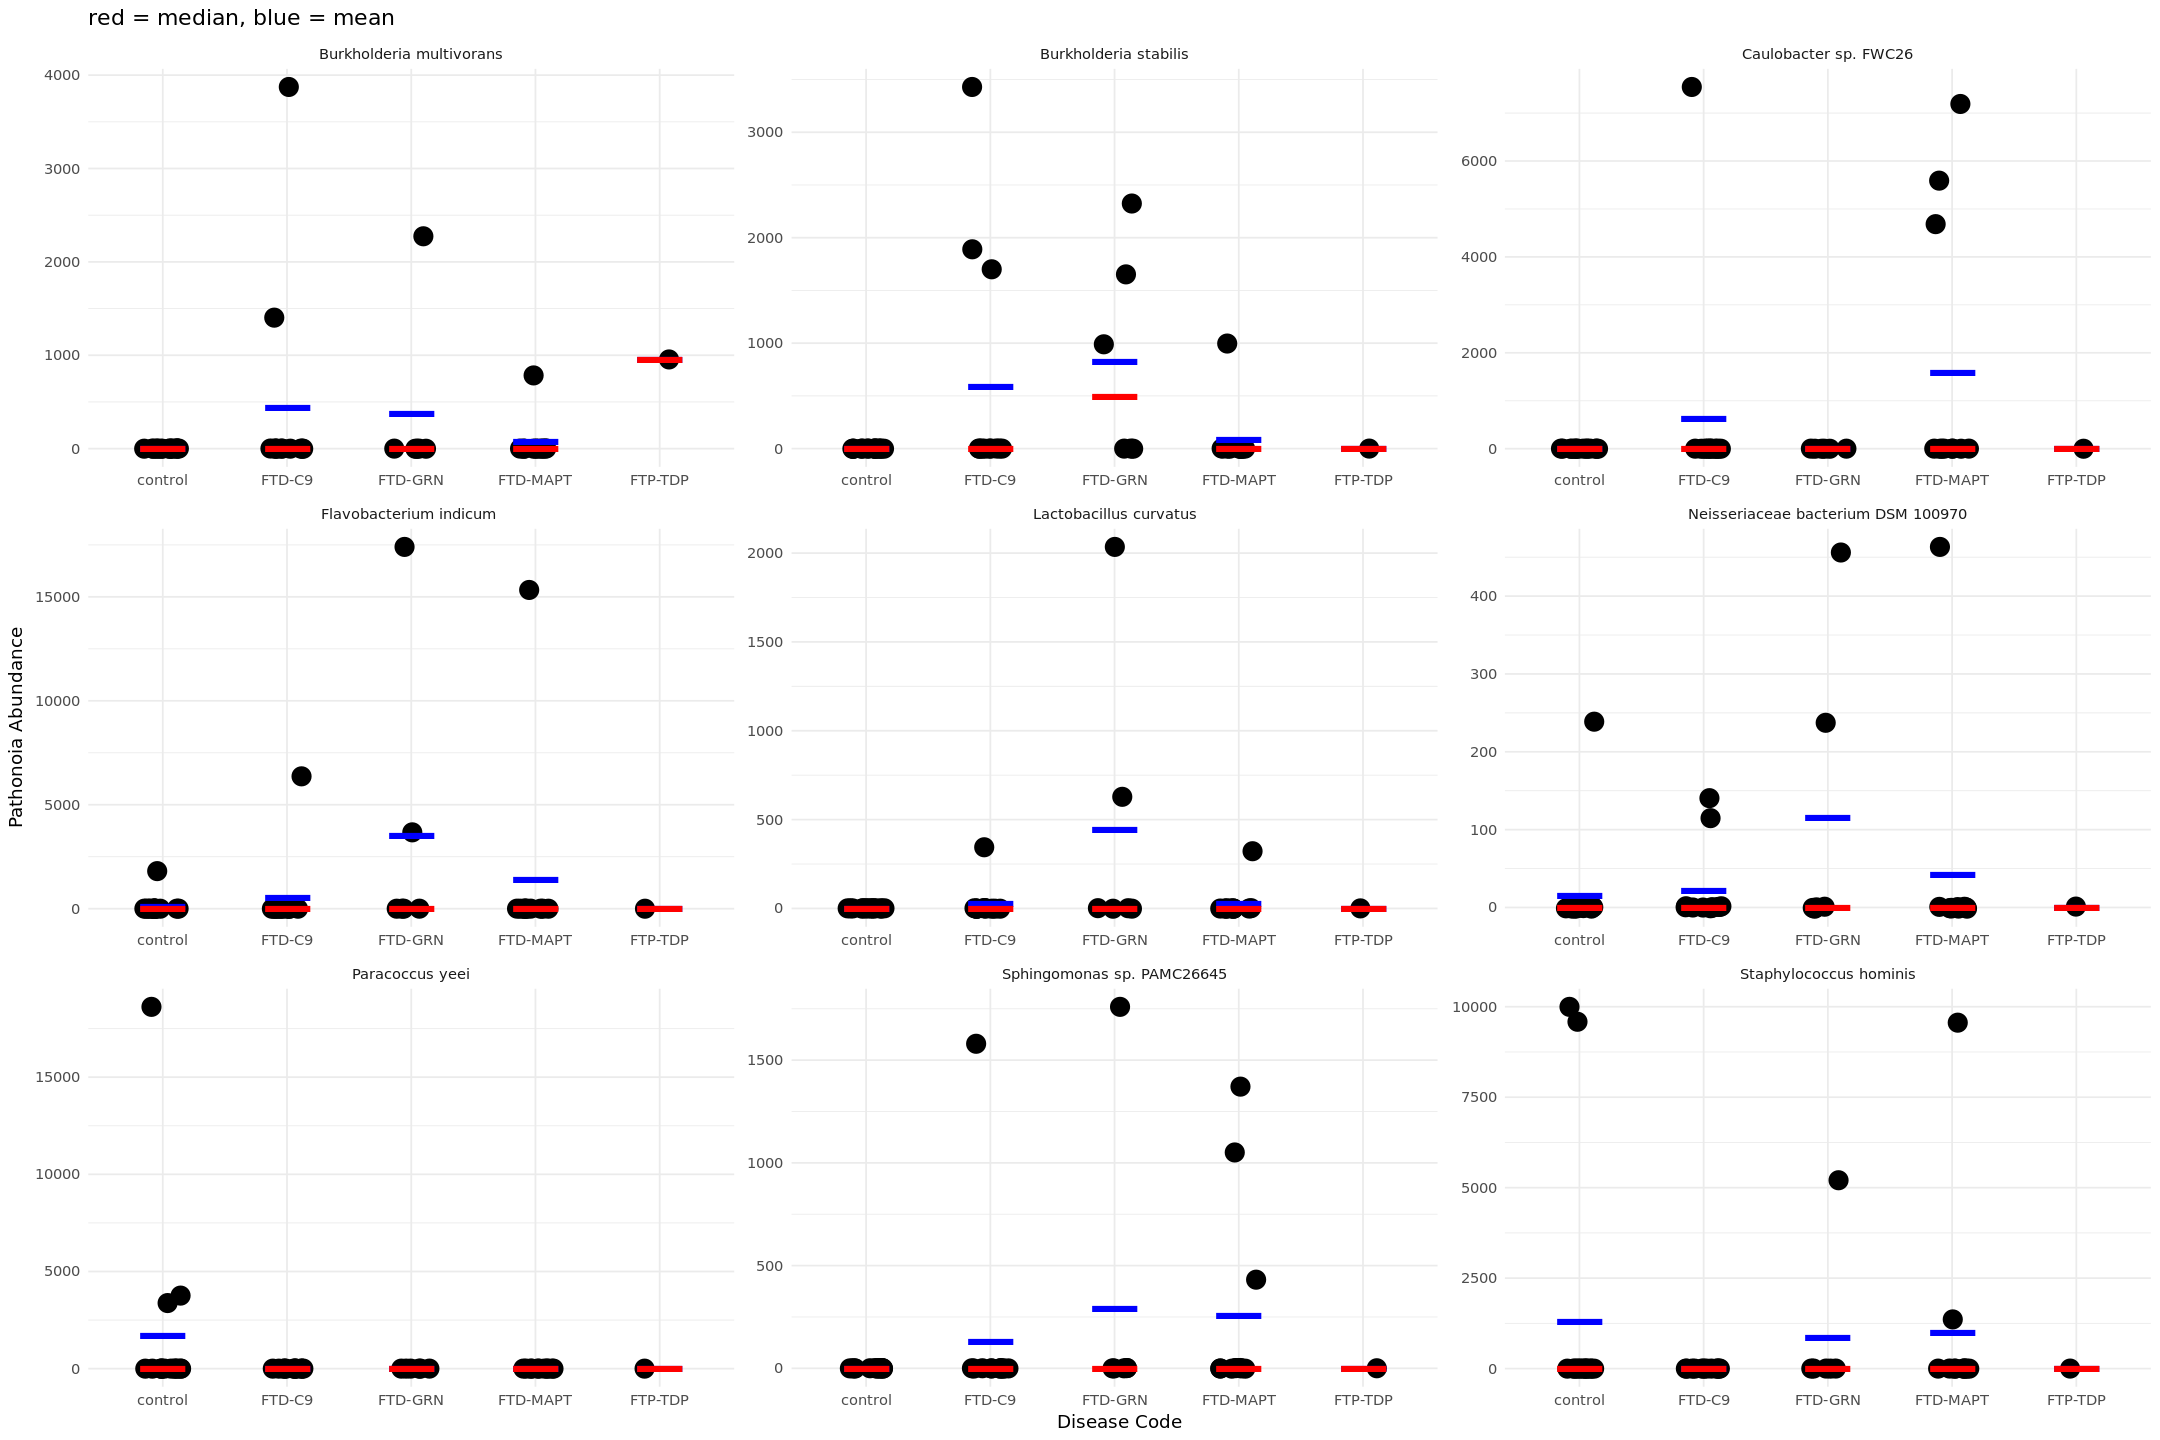

In [35]:
options(repr.plot.width=18, repr.plot.height=12)

t = counts[rownames(r[1:9,]),samples] 
t$organism = r[1:9,"species_name"]
t = gather(t, key = "sample", value = "expression", -organism)
t = cbind(t, cc = metadata_of_interest[t$sample,"DISEASE.CODE"])

t$organism = gsub("GPTSA100-9 = DSM 17447", "", t$organism)
t$cc = gsub("FTD-sporadic-TDP", "FTP-TDP", t$cc)

ggplot(t, aes(x = cc, y = expression)) + theme_minimal() + 
    geom_jitter(width = 0.15, size=5) +
    stat_summary(fun=mean, geom="point", shape=95, size=18, color="blue") + 
    stat_summary(fun=median, geom="point", shape=95, size=18, color="red") +
    facet_wrap(facets = "organism", scales = "free", ncol=3) + 
    ggtitle(paste("red = median, blue = mean")) + xlab("Disease Code") + ylab("Pathonoia Abundance")

In [37]:
r = cbind(r, posi_samples = rowSums(counts[rownames(r),]>0))
r$log10_padj=-log10(r$padj)

In [37]:
r

,species_name,phylo_level,parent,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,posi_samples,log10_padj
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1094466,Flavobacterium indicum GPTSA100-9 = DSM 17447,S1,312277,957.006038,-28.88393,3.105402,-9.301192,1.388803e-20,1.736004e-18,5,17.76045
95485,Burkholderia stabilis,S,87882,220.144848,-26.85486,2.922396,-9.189329,3.952986e-20,2.470616e-18,7,17.60719
69665,Caulobacter sp. FWC26,S,2648921,454.838727,-27.85302,3.105410,-8.969193,2.986949e-19,1.244562e-17,4,16.90498
147645,Paracoccus yeei,S,265,152.087039,27.49398,3.083026,8.917853,4.754130e-19,1.485666e-17,3,16.82808
2565555,Sphingomonas sp. PAMC26645,S,196159,131.383032,-25.71649,3.105450,-8.281084,1.220587e-16,2.702545e-15,5,14.56823
87883,Burkholderia multivorans,S,87882,181.246659,-25.69384,3.105435,-8.273831,1.297222e-16,2.702545e-15,5,14.56823
28038,Lactobacillus curvatus,S,1578,49.674416,-24.74716,3.105542,-7.968707,1.603426e-15,2.863260e-14,4,13.54314
2052837,Neisseriaceae bacterium DSM 100970,S,421605,27.466536,-24.01625,3.105662,-7.733052,1.049980e-14,1.640594e-13,6,12.78500
1290,Staphylococcus hominis,S,1279,25.260805,-23.90268,3.105686,-7.696428,1.399231e-14,1.943377e-13,5,12.71144


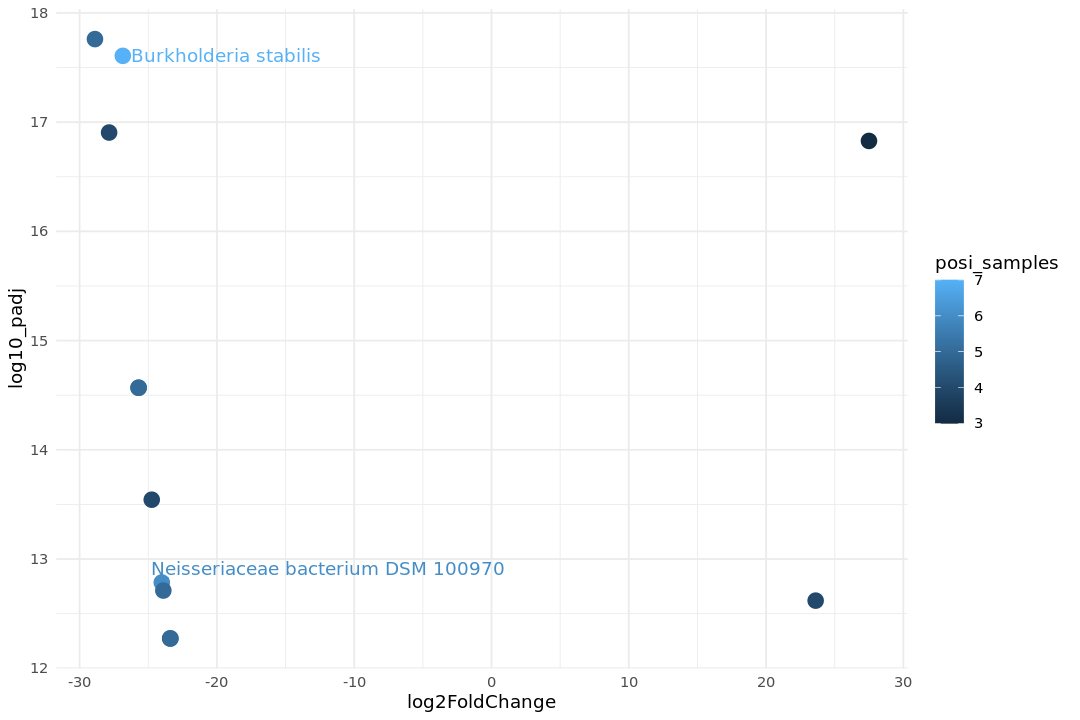

In [38]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(r, aes(log2FoldChange, log10_padj, color= posi_samples, label=ifelse(posi_samples>5, as.character(species_name),""))) + geom_point(size=4) + theme_minimal() + geom_text_repel(min.segment.length = 0) 

# DE Transcriptome

In [6]:
genecounts = read.table(paste0(inputfolder,"/frontal_lengthScaledTPM_counts.txt"), header = TRUE, row.names = 1)
colnames(genecounts) = gsub('X', '', colnames(genecounts))
colnames(genecounts) = substr(colnames(genecounts),1,5)
genecounts = genecounts[,!(colnames(genecounts) %in% pca_outlier)]
colnames(genecounts) = paste0("S",colnames(genecounts))

In [7]:
gderes = read.table(paste0(inputfolder,"/deseq_infected-free_fro_2020-03-12.txt"), header = TRUE, row.names = 1)
gr = gderes[gderes$padj<0.05 & !is.na(gderes$padj),]
gr

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000008056,5608.66642,-0.7733540,0.18132081,-4.265115,1.997996e-05,0.012638303,4.9536093
ENSG00000008853,3880.23322,-0.5557672,0.14042596,-3.957724,7.566729e-05,0.027509381,3.3073412
ENSG00000034677,7190.37835,0.7420781,0.22198859,3.342866,8.291795e-04,0.042669030,5.6907280
ENSG00000055917,6345.73098,-0.1593878,0.04193335,-3.800980,1.441252e-04,0.027850558,5.6907280
ENSG00000068354,597.50677,-0.4738765,0.11025479,-4.298013,1.723364e-05,0.023074769,1.1701069
ENSG00000074276,77.22308,-0.7717767,0.18297221,-4.218000,2.464793e-05,0.029801185,0.6768821
ENSG00000078369,11692.97330,-0.3300636,0.09284569,-3.554969,3.780235e-04,0.037955292,4.9536093
ENSG00000087085,511.60850,-0.6960329,0.16942589,-4.108185,3.987808e-05,0.029801185,1.1168950
ENSG00000087191,1727.35527,-0.3739340,0.10325910,-3.621318,2.931059e-04,0.042669030,2.0271102


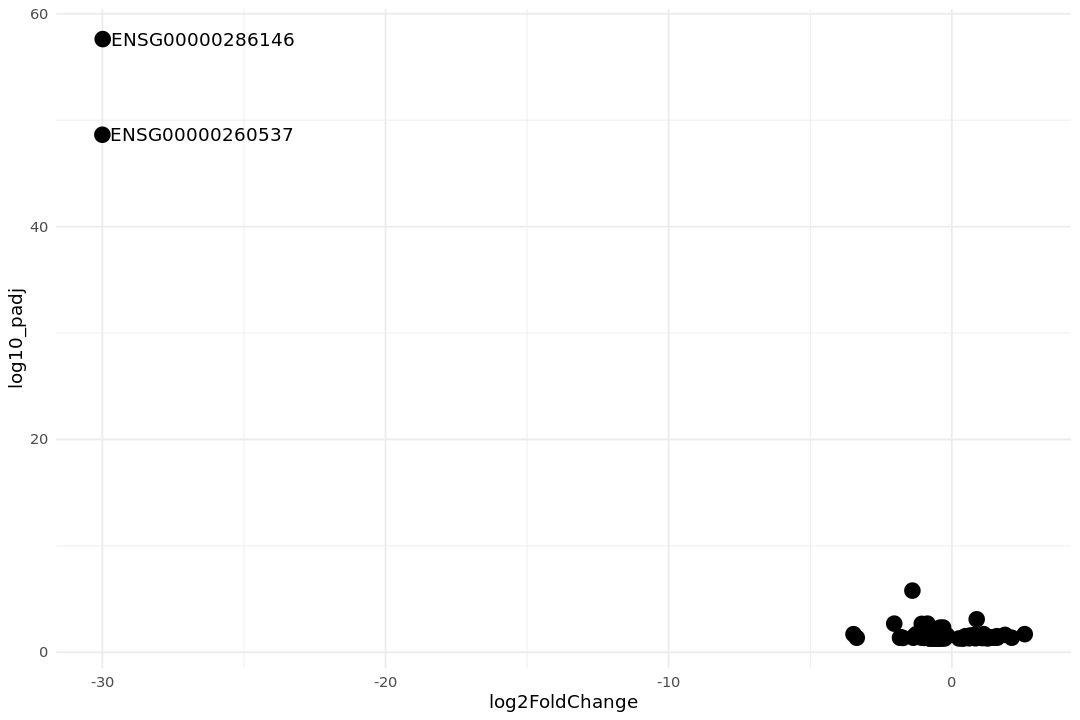

In [10]:
gr$log10_padj=-log10(gr$padj)
gr$genename=rownames(gr)
options(repr.plot.width=9, repr.plot.height=6)
ggplot(gr, aes(log2FoldChange, log10_padj, label=ifelse(log10_padj>40, as.character(genename),"")))+ geom_point(size=4) + theme_minimal() + geom_text_repel(min.segment.length = 0) 

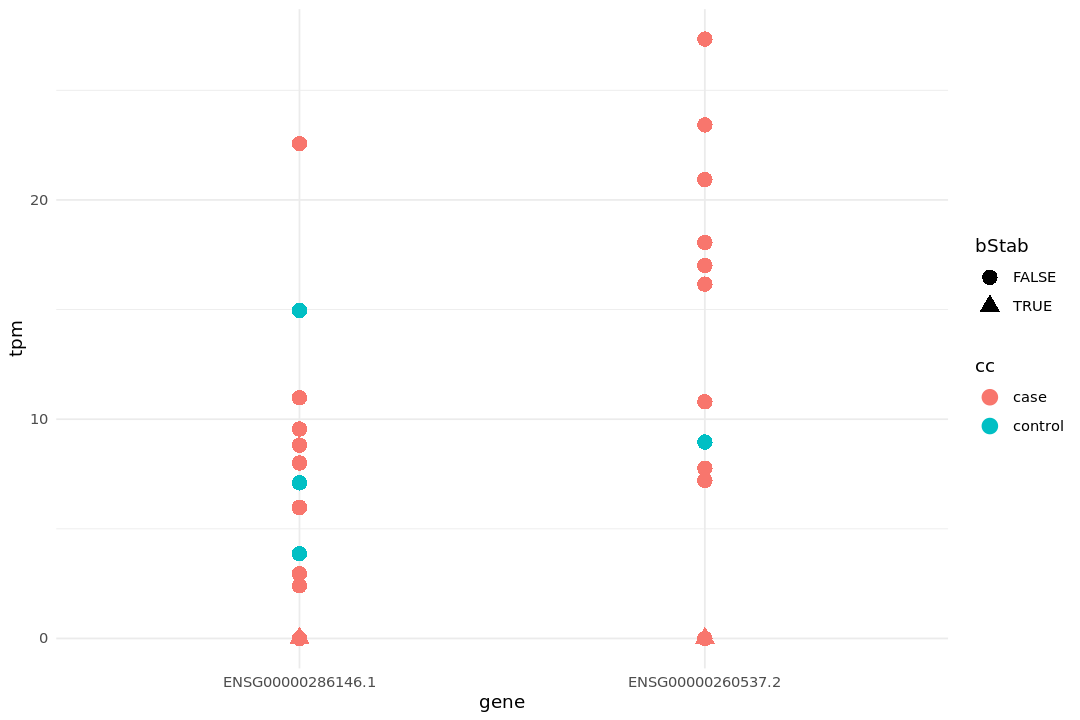

In [16]:
genesOfInterest = genecounts[c("ENSG00000286146","ENSG00000260537"),]
goi = t(genesOfInterest)
goi = melt(goi ,  varnames=c('sample', 'gene'), value.name = 'tpm')
goi$sample = substr(goi$sample,2,6)
goi$cc=metadata[goi$sample,"CASE.CONTROL"]
goi$bStab=t(counts["95485",goi$sample]>0)
ggplot(goi,aes(x=gene, y=tpm, color=cc, shape = bStab)) + geom_point(size=4) + theme_minimal()

In [41]:
upregulated_genes = sapply(strsplit(rownames(gr[gr$log2FoldChange > 0,]), ".", fixed=T), function(x) x[1])
downregulated_genes = sapply(strsplit(rownames(gr[gr$log2FoldChange < 0,]), ".", fixed=T), function(x) x[1])
regulated_genes = sapply(strsplit(rownames(gr), ".", fixed=T), function(x) x[1])
length(upregulated_genes)

[1] 34

In [19]:
WebGes_BioProc <- function(genes, projectname){
    WebGestaltR(enrichMethod="ORA", organism="hsapiens",
    enrichDatabase="geneontology_Biological_Process",
    interestGene=genes,interestGeneType="ensembl_gene_id",referenceGeneType="genesymbol",
    referenceSet="genome_protein-coding", minNum=5, maxNum=2000,
    fdrMethod="BH",sigMethod="fdr",fdrThr=0.05,topThr=10,reportNum=20,perNum=1000,
    nThreads=64,
    isOutput=TRUE,outputDirectory="GO_results/GO_Analysis_biolProcess_FDR05",projectName=projectname,
    dagColor="continuous",hostName="http://www.webgestalt.org/")
}

WebGes_MolFun <- function(genes, projectname){
    WebGestaltR(enrichMethod="ORA", organism="hsapiens",
    enrichDatabase="geneontology_Molecular_Function",
    interestGene=genes,interestGeneType="ensembl_gene_id",referenceGeneType="genesymbol",
    referenceSet="genome_protein-coding", minNum=5, maxNum=2000,
    fdrMethod="BH",sigMethod="fdr",fdrThr=0.05,topThr=10,reportNum=20,perNum=1000,
    nThreads=64,
    isOutput=TRUE,outputDirectory="GO_results/GO_Analysis_molFunction_FDR05",projectName=projectname,
    dagColor="continuous",hostName="http://www.webgestalt.org/")
}



In [20]:
WebGes_BioProc(upregulated_genes, "ftd_95485_upDEgenes")
WebGes_BioProc(downregulated_genes, "ftd_95485_downDEgenes")
WebGes_BioProc(regulated_genes, "ftd_95485_DEgenes")
WebGes_MolFun(upregulated_genes, "ftd_95485_upDEgenes")
WebGes_MolFun(downregulated_genes, "ftd_95485_downDEgenes")
WebGes_MolFun(regulated_genes, "ftd_95485_DEgenes")

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...


Warning message in oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum, :
“No significant gene set is identified based on FDR 0.05!”


NULL

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the GO_results/GO_Analysis_biolProcess_FDR05/Project_ftd_95485_downDEgenes!


geneSet,description,link,size,overlap,expect,enrichmentRatio,pValue,FDR,overlapId,userId
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0007268,chemical synaptic transmission,http://amigo.geneontology.org/amigo/term/GO:0007268,685,13,3.0829933,4.216681,1.028871e-05,0.02857357,43;2030;2931;3780;5705;6844;6853;11346;23316;27445;59283;84446;112755,ENSG00000008056;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0098916,anterograde trans-synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0098916,685,13,3.0829933,4.216681,1.028871e-05,0.02857357,43;2030;2931;3780;5705;6844;6853;11346;23316;27445;59283;84446;112755,ENSG00000008056;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0099537,trans-synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0099537,693,13,3.1189990,4.168004,1.164588e-05,0.02857357,43;2030;2931;3780;5705;6844;6853;11346;23316;27445;59283;84446;112755,ENSG00000008056;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0099536,synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0099536,698,13,3.1415026,4.138147,1.257224e-05,0.02857357,43;2030;2931;3780;5705;6844;6853;11346;23316;27445;59283;84446;112755,ENSG00000008056;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0001505,regulation of neurotransmitter levels,http://amigo.geneontology.org/amigo/term/GO:0001505,335,9,1.5077412,5.969194,1.884091e-05,0.03346615,43;570;2030;6844;6853;27445;84446;112755;140885,ENSG00000008056;ENSG00000087085;ENSG00000099365;ENSG00000112759;ENSG00000136881;ENSG00000160469;ENSG00000186472;ENSG00000198053;ENSG00000220205
GO:0051049,regulation of transport,http://amigo.geneontology.org/amigo/term/GO:0051049,1765,21,7.9437710,2.643581,2.208744e-05,0.03346615,43;476;2931;3098;3737;3748;3787;4744;6548;6844;6853;9919;22848;27445;57118;59283;84446;89866;112755;140885;192683,ENSG00000008056;ENSG00000087085;ENSG00000090020;ENSG00000099365;ENSG00000100285;ENSG00000105723;ENSG00000115977;ENSG00000120341;ENSG00000124134;ENSG00000131398;ENSG00000142408;ENSG00000148396;ENSG00000156515;ENSG00000160469;ENSG00000163399;ENSG00000177301;ENSG00000183049;ENSG00000186472;ENSG00000198053;ENSG00000198794;ENSG00000220205
GO:0071804,cellular potassium ion transport,http://amigo.geneontology.org/amigo/term/GO:0071804,202,7,0.9091455,7.699538,3.425928e-05,0.03871097,476;3737;3748;3780;3787;6548;6844,ENSG00000090020;ENSG00000105642;ENSG00000124134;ENSG00000131398;ENSG00000163399;ENSG00000177301;ENSG00000220205
GO:0071805,potassium ion transmembrane transport,http://amigo.geneontology.org/amigo/term/GO:0071805,202,7,0.9091455,7.699538,3.425928e-05,0.03871097,476;3737;3748;3780;3787;6548;6844,ENSG00000090020;ENSG00000105642;ENSG00000124134;ENSG00000131398;ENSG00000163399;ENSG00000177301;ENSG00000220205
GO:0097091,synaptic vesicle clustering,http://amigo.geneontology.org/amigo/term/GO:0097091,15,3,0.0675108,44.437333,3.832348e-05,0.03871097,6853;27445;84446,ENSG00000008056;ENSG00000160469;ENSG00000186472


Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the GO_results/GO_Analysis_biolProcess_FDR05/Project_ftd_95485_DEgenes!


geneSet,description,link,size,overlap,expect,enrichmentRatio,pValue,FDR,overlapId,userId
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0007268,chemical synaptic transmission,http://amigo.geneontology.org/amigo/term/GO:0007268,685,15,3.617379,4.146649,2.702364e-06,0.007729964,43;2030;2931;3780;5025;5705;6844;6853;11346;23316;25897;27445;59283;84446;112755,ENSG00000008056;ENSG00000034677;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000135124;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0098916,anterograde trans-synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0098916,685,15,3.617379,4.146649,2.702364e-06,0.007729964,43;2030;2931;3780;5025;5705;6844;6853;11346;23316;25897;27445;59283;84446;112755,ENSG00000008056;ENSG00000034677;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000135124;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0099537,trans-synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0099537,693,15,3.659626,4.098780,3.115219e-06,0.007729964,43;2030;2931;3780;5025;5705;6844;6853;11346;23316;25897;27445;59283;84446;112755,ENSG00000008056;ENSG00000034677;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000135124;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0099536,synaptic signaling,http://amigo.geneontology.org/amigo/term/GO:0099536,698,15,3.686030,4.069419,3.401150e-06,0.007729964,43;2030;2931;3780;5025;5705;6844;6853;11346;23316;25897;27445;59283;84446;112755,ENSG00000008056;ENSG00000034677;ENSG00000087085;ENSG00000087191;ENSG00000099365;ENSG00000105642;ENSG00000105723;ENSG00000111249;ENSG00000112759;ENSG00000135124;ENSG00000142408;ENSG00000160469;ENSG00000171992;ENSG00000186472;ENSG00000220205
GO:0001505,regulation of neurotransmitter levels,http://amigo.geneontology.org/amigo/term/GO:0001505,335,10,1.769083,5.652646,1.060751e-05,0.019286569,43;570;2030;5025;6844;6853;27445;84446;112755;140885,ENSG00000008056;ENSG00000087085;ENSG00000099365;ENSG00000112759;ENSG00000135124;ENSG00000136881;ENSG00000160469;ENSG00000186472;ENSG00000198053;ENSG00000220205
GO:0051049,regulation of transport,http://amigo.geneontology.org/amigo/term/GO:0051049,1765,23,9.320691,2.467628,3.100675e-05,0.046980398,43;476;2931;3098;3737;3748;3787;4744;5025;6548;6844;6853;9173;9919;22848;27445;57118;59283;84446;89866;112755;140885;192683,ENSG00000008056;ENSG00000087085;ENSG00000090020;ENSG00000099365;ENSG00000100285;ENSG00000105723;ENSG00000115602;ENSG00000115977;ENSG00000120341;ENSG00000124134;ENSG00000131398;ENSG00000135124;ENSG00000142408;ENSG00000148396;ENSG00000156515;ENSG00000160469;ENSG00000163399;ENSG00000177301;ENSG00000183049;ENSG00000186472;ENSG00000198053;ENSG00000198794;ENSG00000220205


Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the GO_results/GO_Analysis_molFunction_FDR05/Project_ftd_95485_upDEgenes!


geneSet,description,link,size,overlap,expect,enrichmentRatio,pValue,FDR,overlapId,userId
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0004908,interleukin-1 receptor activity,http://amigo.geneontology.org/amigo/term/GO:0004908,7,2,0.005039597,396.85714,9.958261e-06,0.01869166,8809;9173,ENSG00000115602;ENSG00000115604
GO:0004896,cytokine receptor activity,http://amigo.geneontology.org/amigo/term/GO:0004896,92,3,0.066234701,45.29348,3.453416e-05,0.03241031,8809;9173;132014,ENSG00000115602;ENSG00000115604;ENSG00000163701


Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the GO_results/GO_Analysis_molFunction_FDR05/Project_ftd_95485_downDEgenes!


geneSet,description,link,size,overlap,expect,enrichmentRatio,pValue,FDR,overlapId,userId
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0008092,cytoskeletal protein binding,http://amigo.geneontology.org/amigo/term/GO:0008092,940,14,3.8348932,3.650688,2.117962e-05,0.03975414,476;2036;2782;2931;3737;4741;4744;6853;10296;10391;11346;51517;84446;221692,ENSG00000008056;ENSG00000078369;ENSG00000088367;ENSG00000090316;ENSG00000100285;ENSG00000103647;ENSG00000104722;ENSG00000105723;ENSG00000112137;ENSG00000160469;ENSG00000163399;ENSG00000171992;ENSG00000177301;ENSG00000213672
GO:0015079,potassium ion transmembrane transporter activity,http://amigo.geneontology.org/amigo/term/GO:0015079,160,6,0.6527478,9.191912,4.769464e-05,0.04476142,476;3737;3748;3780;3787;6548,ENSG00000090020;ENSG00000105642;ENSG00000124134;ENSG00000131398;ENSG00000163399;ENSG00000177301


Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...


Warning message in oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum, :
“No significant gene set is identified based on FDR 0.05!”


NULL

### Dataset Information

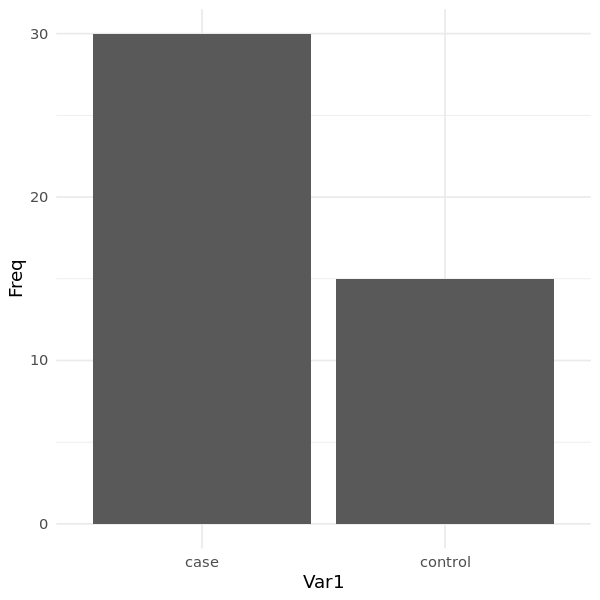

In [48]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(data = data.frame(table(metadata["CASE.CONTROL"])), aes(x=Var1, y=Freq)) + geom_bar(stat="identity") + theme_minimal()

In [60]:
counts

,98169,00116,00136,02218,03121,04245,04263,05052,05108,05150,⋯,12005,12042,12062,92017,95231,96303,97231,97303,98061,A144_
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1969841,784878,787603,1767160,815657,409385,658210,611432,674349,1011913,729985,⋯,1232338,721444,520557,983627,531811,966923,908890,600373,527048,619966
1491,275687,211559,565891,107180,135795,157907,129659,180864,287619,123936,⋯,302256,211633,175128,281413,115404,370109,102240,97523,122184,248608
44283,250349,178052,314226,193425,84103,82057,115603,150475,247195,121768,⋯,380059,180750,160643,193625,88567,203249,190972,105667,150929,70332
2184519,182899,146714,338136,92401,90792,140170,88644,122950,190231,89462,⋯,187675,133276,114146,179315,82865,255550,97202,70975,94973,178202
72407,148016,111606,219617,203689,95668,125445,109171,110018,140268,121389,⋯,218914,127300,118961,154373,94710,127610,201013,150345,105778,93587
166122,108947,72110,168005,195923,70490,109628,94213,69296,116288,89576,⋯,154073,101008,100604,107446,63142,84112,178360,111986,84712,43638
550,70922,57438,130686,113399,47216,66979,55349,55215,62535,49731,⋯,115267,60772,57651,73459,45680,58092,118177,85011,49954,47667
485,36097,31883,51442,52549,31771,35855,33252,31540,37156,36666,⋯,45864,35341,33450,38557,28748,35942,50900,40444,32287,26406
527028,38006,45543,46180,6325,14673,16389,10324,40549,56947,16345,⋯,43520,24657,19844,17491,18665,49042,7106,15270,15075,14606
